In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.special import erf

In [2]:
# For dealing with very large exponents, stolen from Wikipedia
def exp_by_squaring(x, pows):
    for n in pows:
        if n < 0:
            return exp_by_squaring(1 / x, -n);
        elif n == 0:
            return  1
        elif n == 1:
            return  x
        elif n is even:
            return exp_by_squaring(x * x,  n / 2)
        elif n is odd:
            return x * exp_by_squaring(x * x, (n - 1) / 2)

In [3]:
# probability from Eq. (20) in Epstein
def epstein_spherical_centre(k, delta):
    return (delta/(1+delta)) * exp_by_squaring((k/(1+delta)), k-1) * np.exp(-k/(1+delta)) / factorial(k-1)

# halo mass function from Inman \& Ali-Haimoud (2019):
def inman_ah(n, n_pbh, delta):
    return (n_pbh / n) * epstein_spherical_centre(n, delta)

# expression for N_*, given in Inman \& Ali-Haimoud (2019)
def n_star(delta):
    return 1 / (np.log(1+delta) - (delta / (1+delta)))

# discrete pdf from Press-Schechter formalism, from Hutsi, Veermae & Raidal (2019)
def press_schechter_discrete(n, delta):
    n_s = n_star(delta)
    return erf(np.sqrt(n/n_s)) - erf(np.sqrt((n-1)/n_s))

# continuous pdf from Press-Schechter formalism, from Hutsi, Veermae & Raidal (2019)
def press_schechter_continuous(n, delta):
    n_s = n_star(delta)
    return np.sqrt(n_s/n) * np.exp(-n/n_s)

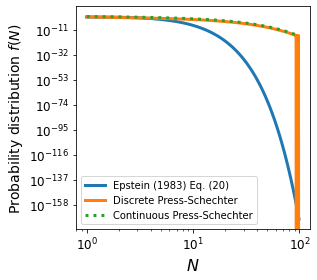

In [4]:
x = np.arange(1, 100)
delta = 1.686

fig = plt.figure(figsize=(4.5,4))
plt.plot(x, epstein_spherical_centre(x, delta), label='Epstein (1983) Eq. (20)', linewidth=3)
#plt.plot(x, inman_ah(x, 1., delta), label='Inman & Ali_Haïmoud (2019) Eq. (46)')
plt.plot(x, press_schechter_discrete(x, delta), label='Discrete Press-Schechter', linewidth=3)
plt.plot(x, press_schechter_continuous(x, delta), label='Continuous Press-Schechter', linewidth=3, linestyle=':')
plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')

#plt.xlim(1, 110)
ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn.pdf')

134.6153846153846
500.0
42.56912234842049
158.11388300841898
13.461538461538463
50.00000000000001


<Figure size 432x288 with 0 Axes>

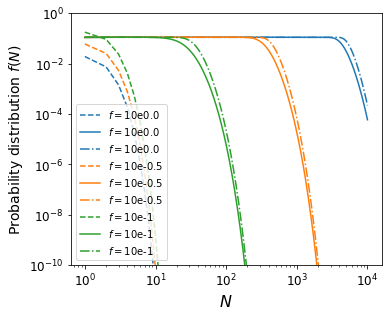

f 1.0
116.66666666666667
433.33333333333337
f 0.31622776601683794
36.89323936863109
137.0320319406298
f 0.1
11.666666666666668
43.333333333333336


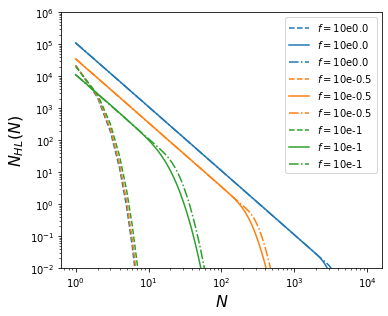

In [64]:
from scipy.optimize import fsolve

plt.clf()

# implicit equation to solve for kappa:
def f(kappa, params):
    delta, p_t = params
    return np.log(p_t/delta) + 0.5*np.log(2*kappa/np.pi) - kappa

def interior_prob_spherical_anywhere(k, k_m, kappa):
    return 1 - np.exp(-np.sqrt(k/k_m) * np.exp( - kappa * (k/k_m - 1)))

# Epstein results
def epstein_spherical_anywhere(k, delta, p_t):
    
    # estimate for the input value of kappa
    est_kappa = np.log(p_t/delta)+1
    
    kappa = fsolve(f, est_kappa, args=([delta, p_t]))
    # since fsolve isn't converging a lot of the time, use approximate value of kappa
    #kappa = est_kappa
    print(p_t/delta)
    k_m = 2*kappa / delta **2
    f_ia = interior_prob_spherical_anywhere(k, k_m, kappa)
    
    kvals = np.arange(0, 10)
    f_ea = 1 / np.sum(interior_prob_spherical_anywhere(kvals, k_m, kappa))
        
    return f_ia * f_ea


def epstein_non_spherical_anywhere(k, delta, eta):
    return(epstein_spherical_anywhere(k, delta, (8*eta**3 - 1)))



x = np.arange(1, 10000)
p_t = 7
eta = 1.5

pows = (0., -0.5, -1, -3/2, -2)
pows = (0., -0.5, -1)


fig = plt.figure(figsize=(5.5,4.5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.052 / q   # at z=99
    plt.plot(x, epstein_spherical_centre(x, delta), linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_spherical_anywhere(x, delta, p_t), label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_non_spherical_anywhere(x, delta, eta), linestyle = '-.', label='$f = 10$e{}'.format(j), color=colors[i])
    
    
plt.ylim(10**(-10), 1.)

plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')


ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn_epstein.pdf')
plt.show()



fig2 = plt.figure(figsize=(5.5,4.5))

#get colour cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.052 / q   # at z=99
    print('f', q)
    delta_N = x**(1)
    plt.plot(x, (10e5*q/x) * epstein_spherical_centre(x, delta) / delta_N, linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_spherical_anywhere(x, delta, p_t) / delta_N, label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_non_spherical_anywhere(x, delta, eta) / delta_N, linestyle = '-.', label='$f = 10$e{}'.format(j), color=colors[i])    
    
plt.ylabel('$N_{HL}(N)$', fontsize=16)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**(-2), 10**6)

ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('n_epstein.pdf')
